### Generating the node2vec embeddings

In [1]:
# # uncomment to regenerate the embeddings
# %%bash
# cd ./node2vec/
# make all
# ./node2vec -v -i:../graphs/fb_edges.txt -o:../embeddings/fb_node2vec.emb

### Generating the fairwalk embeddings

In [2]:
# # uncomment to regenerate the embeddings
# %%bash
# python3 ./fairwalk/Code/main.py

### Generating the residual fair node2vec embeddings

In [3]:
# # uncomment to regenerate the embeddings
# %%bash
# cd ./fn2v/
# make fair_node2vec
# ./fair_node2vec -v -i:../graphs/fb_edges.txt -iattr: ../graphs/fb_genders -oe:../embeddings/fb_fn2v_embs.txt

### Training the link recommendation models 

In [4]:
import numpy as np

import matplotlib.pyplot as plt

import pathlib

import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.metrics.pairwise import cosine_similarity

rng = np.random.default_rng(seed=0)

In [5]:
nodes = 4039

edges = np.loadtxt("./graphs/fb_edges.txt", dtype=int, skiprows=1)

sample_size = len(edges)

pairs_without_edges = np.ones((nodes, nodes))
pairs_without_edges[np.diag_indices(nodes)] = 0
pairs_without_edges[edges[:,0], edges[:,1]] = 0
pairs_without_edges[edges[:,1], edges[:,0]] = 0
pairs_without_edges[np.tril_indices(nodes, k=0, m=nodes)] = 0
pairs_without_edges = np.array(np.nonzero(pairs_without_edges)).T
pairs_without_edges = rng.choice(pairs_without_edges, sample_size, replace=False, shuffle=False)

node_pairs = np.vstack([edges, edges[:,::-1], pairs_without_edges, pairs_without_edges[:,::-1]])
y = np.hstack([np.ones(2*sample_size), np.zeros(2*sample_size)])

pairs_train, pairs_test, y_train, y_test = train_test_split(node_pairs, y, test_size=0.2, random_state=0)

In [6]:
node2vec_node_embeddings = np.sort(np.loadtxt("./embeddings/fb_node2vec.emb", skiprows=1), axis=0)[:,1:]

fairwalk_node_embeddings = np.zeros((nodes, 128))
for file_path in pathlib.Path("./fairwalk/Embeddings/").iterdir():
    tmp = np.loadtxt(file_path, skiprows=1)
    for row in tmp:
        fairwalk_node_embeddings[int(row[0])] = row[1:]
    
fn2v_node_embeddings = np.sort(np.loadtxt("./embeddings/fb_fn2v_embs.txt", skiprows=1), axis=0)[:,1:]

In [7]:
def hadamard_embeddings(node_embeddings, node_pairs):
    return node_embeddings[node_pairs[:,0]]*node_embeddings[node_pairs[:,1]]

In [8]:
X_train_node2vec = hadamard_embeddings(node2vec_node_embeddings, pairs_train) 
X_test_node2vec  = hadamard_embeddings(node2vec_node_embeddings, pairs_test)

X_train_fairwalk = hadamard_embeddings(fairwalk_node_embeddings, pairs_train)
X_test_fairwalk  = hadamard_embeddings(fairwalk_node_embeddings, pairs_test)

X_train_fn2v = hadamard_embeddings(fn2v_node_embeddings, pairs_train)
X_test_fn2v  = hadamard_embeddings(fn2v_node_embeddings, pairs_test)

In [9]:
rfc_node2vec_path= pathlib.Path("./models/rfc_node2vec_model.pkl")


if rfc_node2vec_path.exists():
    
    with open(rfc_node2vec_path, "rb") as file:
        rfc_node2vec = pickle.load(file)
        
else:
    
    rfc_node2vec = RandomForestClassifier(max_depth=10, random_state=0, verbose=3, n_jobs=-1)
    rfc_node2vec.fit(X_train_node2vec, y_train)
    
    with open(rfc_node2vec_path, "wb") as file:
        pickle.dump(rfc_node2vec, file)


print("\nThe classification report on the train data\n", classification_report(y_train, rfc_node2vec.predict(X_train_node2vec)))
print("\nThe classification report on the test data\n",  classification_report(y_test,  rfc_node2vec.predict(X_test_node2vec)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished



The classification report on the train data
               precision    recall  f1-score   support

         0.0       0.94      0.67      0.78    141376
         1.0       0.74      0.95      0.84    140972

    accuracy                           0.81    282348
   macro avg       0.84      0.81      0.81    282348
weighted avg       0.84      0.81      0.81    282348



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished



The classification report on the test data
               precision    recall  f1-score   support

         0.0       0.93      0.67      0.78     35092
         1.0       0.74      0.95      0.84     35496

    accuracy                           0.81     70588
   macro avg       0.84      0.81      0.81     70588
weighted avg       0.84      0.81      0.81     70588



In [10]:
rfc_fairwalk_path = pathlib.Path("./models/rfc_fairwalk_model.pkl")


if rfc_fairwalk_path.exists():
    
    with open(rfc_fairwalk_path, "rb") as file:
        rfc_fairwalk = pickle.load(file)
        
else:
    
    rfc_fairwalk = RandomForestClassifier(max_depth=10, random_state=0, verbose=3, n_jobs=-1)
    rfc_fairwalk.fit(X_train_fairwalk, y_train)
    
    with open(rfc_fairwalk_path, "wb") as file:
        pickle.dump(rfc_fairwalk, file)


print("\nThe classification report on the train data\n", classification_report(y_train, rfc_fairwalk.predict(X_train_fairwalk)))
print("\nThe classification report on the test data\n",  classification_report(y_test,  rfc_fairwalk.predict(X_test_fairwalk)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished



The classification report on the train data
               precision    recall  f1-score   support

         0.0       0.92      0.94      0.93    141376
         1.0       0.94      0.91      0.93    140972

    accuracy                           0.93    282348
   macro avg       0.93      0.93      0.93    282348
weighted avg       0.93      0.93      0.93    282348



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished



The classification report on the test data
               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     35092
         1.0       0.93      0.90      0.91     35496

    accuracy                           0.92     70588
   macro avg       0.92      0.92      0.92     70588
weighted avg       0.92      0.92      0.92     70588



In [11]:
rfc_fn2v_path= pathlib.Path("./models/rfc_fn2v_model.pkl")


if rfc_fn2v_path.exists():
    
    with open(rfc_fn2v_path, "rb") as file:
        rfc_fn2v = pickle.load(file)
        
else:
    
    rfc_fn2v = RandomForestClassifier(max_depth=10, random_state=0, verbose=3, n_jobs=-1)
    rfc_fn2v.fit(X_train_fn2v, y_train)
    
    with open(rfc_fn2v_path, "wb") as file:
        pickle.dump(rfc_fn2v, file)


print("\nThe classification report on the train data\n", classification_report(y_train, rfc_fn2v.predict(X_train_fn2v)))
print("\nThe classification report on the test data\n",  classification_report(y_test,  rfc_fn2v.predict(X_test_fn2v)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished



The classification report on the train data
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.89    141376
         1.0       0.84      0.98      0.90    140972

    accuracy                           0.90    282348
   macro avg       0.91      0.90      0.89    282348
weighted avg       0.91      0.90      0.89    282348



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s



The classification report on the test data
               precision    recall  f1-score   support

         0.0       0.98      0.80      0.88     35092
         1.0       0.83      0.98      0.90     35496

    accuracy                           0.89     70588
   macro avg       0.91      0.89      0.89     70588
weighted avg       0.91      0.89      0.89     70588



[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


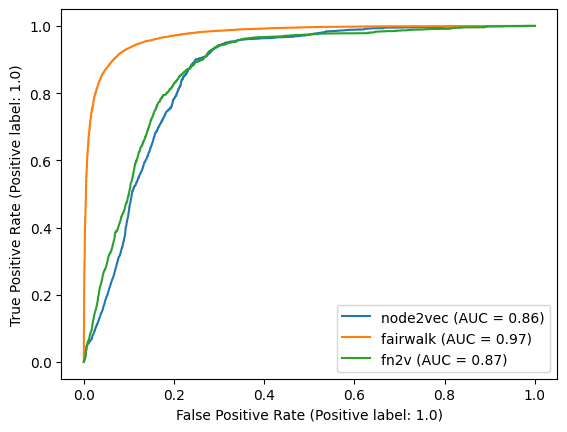

In [12]:
ax = plt.subplot()

RocCurveDisplay.from_estimator(rfc_node2vec, X_test_node2vec, y_test, name="node2vec", ax=ax)
RocCurveDisplay.from_estimator(rfc_fairwalk, X_test_fairwalk, y_test, name="fairwalk", ax=ax)
RocCurveDisplay.from_estimator(rfc_fn2v, X_test_node2vec, y_test, name="fn2v", ax=ax)

In [13]:
test_recommendation_sample_size = 1000
test_nodes = rng.choice(np.arange(nodes), test_recommendation_sample_size, replace=False, shuffle=False)

In [14]:
pairs_without_edges = np.ones((nodes, nodes))
pairs_without_edges[np.diag_indices(nodes)] = 0
pairs_without_edges[edges[:,0], edges[:,1]] = 0
pairs_without_edges[edges[:,1], edges[:,0]] = 0

In [15]:
def get_recommendations(group_of_nodes, estimator, node_embeddings, num_to_keep=100, topk=20):
    recommendations = []
    
    cosine_similarities = cosine_similarity(node_embeddings)

    for node in group_of_nodes:
        indices_of_not_linked_nodes = np.argwhere(pairs_without_edges[node]>0)
        
        most_similar_not_linked = indices_of_not_linked_nodes[
            np.argsort(cosine_similarities[node][indices_of_not_linked_nodes].squeeze())
        ][::-1][:num_to_keep].squeeze()
        
        candidate_links = np.zeros((num_to_keep,2), dtype=int)
        candidate_links[:,0] = node
        candidate_links[:,1] = most_similar_not_linked
        
        embedded_candidate_links = hadamard_embeddings(node_embeddings, candidate_links)
        
        recommendation_indices = np.argsort(estimator.predict_log_proba(embedded_candidate_links)[:,1])[::-1][:topk]
        
        recommendations.append(candidate_links[recommendation_indices])
        
    return recommendations

In [16]:
def get_node2vec_recommendations(group_of_nodes):
    return get_recommendations(group_of_nodes, rfc_node2vec, node2vec_node_embeddings)

def get_fairwalk_recommendations(group_of_nodes):
    return get_recommendations(group_of_nodes, rfc_fairwalk, fairwalk_node_embeddings)

def get_fn2v_recommendations(group_of_nodes):
    return get_recommendations(group_of_nodes, rfc_fn2v, fn2v_node_embeddings)

In [17]:
node2vec_recommendations = get_node2vec_recommendations(test_nodes)
fairwalk_recommendations = get_fairwalk_recommendations(test_nodes)
fn2v_recommendations = get_fn2v_recommendations(test_nodes)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_job

### Evaluating fairness

In [18]:
genders = np.loadtxt("./graphs/fb_genders", dtype=int, skiprows=1)

Gender 1 is the protected attribute:

In [19]:
protected_gender = 1

gender1_nodes = genders[genders[:,1]==1][:,0]
gender2_nodes = genders[genders[:,1]==2][:,0]

gender1_nodes.size/nodes, gender2_nodes.size/nodes

(0.3894528348601139, 0.6105471651398862)

In [20]:
def z_share(gender, recommended_users):
    return np.in1d(recommended_users, gender1_nodes if gender==1 else gender2_nodes).sum()/recommended_users.size
    
def average_z_share(gender, recommendations):
    return np.mean([z_share(gender, user_recommendations) for user_recommendations in recommendations])
    
def user_equality_of_representation(gender, recommendations):
    return 0.5 - average_z_share(gender, recommendations)

The average z-share of the protected gender

In [21]:
(average_z_share(protected_gender, node2vec_recommendations),
 average_z_share(protected_gender, fairwalk_recommendations),
 average_z_share(protected_gender, fn2v_recommendations))

(0.384, 0.38975, 0.385975)

The equality of representation of the protected gender

In [22]:
(user_equality_of_representation(protected_gender, node2vec_recommendations),
 user_equality_of_representation(protected_gender, fairwalk_recommendations),
 user_equality_of_representation(protected_gender, fn2v_recommendations))

(0.11599999999999999, 0.11025000000000001, 0.11402499999999999)